In [1]:
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import grid_utils
import os
import grid as stimgrid
import subtract_utils
from sklearn.linear_model import Ridge

In [41]:
ms_results_path = "220310_cell1_sst__A_grid_subtractr_caviar_results.npz"
ss_results_path = "220310_cell1_sst__A_planes_subtractr_caviar_results.npz"


if ss_results_path is not None:
    ss_results = np.load(ss_results_path, allow_pickle=True)
    ss_model = ss_results['model'].item()

if ms_results_path is not None:
    ms_results = np.load(ms_results_path, allow_pickle=True)
    ms_model = ms_results['model'].item()


In [42]:
ss_weights = ss_model.state['mu'].reshape(26,26,1)
ms_weights = ms_model.state['mu'].reshape(26,26,5)

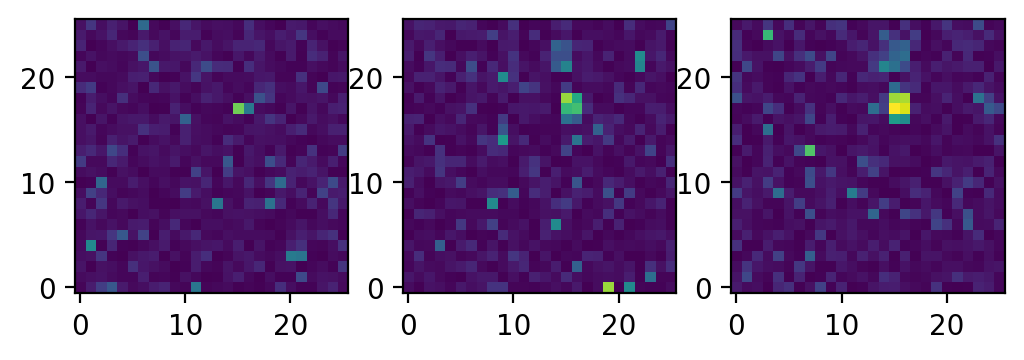

In [92]:
fig, axs = plt.subplots(1,3, dpi=200)
for i,ax in enumerate(axs):
    im = ax.imshow(ss_results['demixed_map'][i,...], origin='lower',
        vmin=0, vmax=np.max(ss_results['demixed_map']))
# plt.colorbar(im)

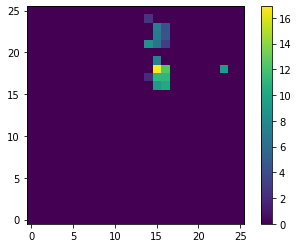

In [43]:
plt.imshow(ss_weights, origin='lower')
plt.colorbar()

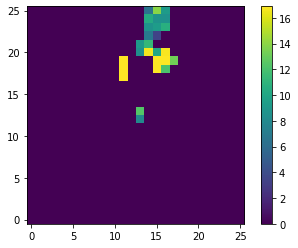

In [86]:
plt.imshow(ms_weights[:,:,3], origin='lower', vmin=np.min(ss_weights,), vmax=(np.max(ss_weights)))
plt.colorbar()

In [32]:

ss_locs = np.array([x for x in ss_results['loc_map'].item().keys()]).reshape(26,26,1,3)
ms_locs = np.array([x for x in ms_results['loc_map'].item().keys()]).reshape(26,26,5,3)

assert np.all(ss_locs[:,:,0] == ms_locs[:,:,0])

In [83]:
first_idxs = [ms_results['loc_map'].item()[tuple(loc)] for loc in ms_results['L'][-1]]
[x for x in sorted(first_idxs)]

[271, 278, 921, 1220, 1240, 1396, 2036, 2088, 3109, 3273]

<StemContainer object of 3 artists>

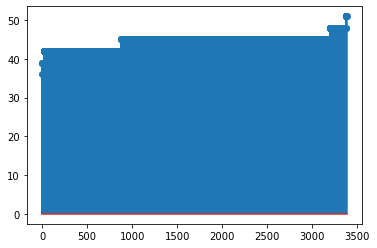

In [93]:
plt.stem(sorted((ms_results['stim_mat'] > 0).sum(1)))

In [5]:
def make_grid_waveforms(model, psc, I, grid=None):
    if grid is None:
        grid = stimgrid.make_default_grid()
    
    # pull I vector from first plane, use it to find number of unique powers
    # for this dataset
    powers = np.unique(I) # powers for first plane
    
    psc_length = psc[0].shape[-1]
    grid_dims = grid.dims
    grid_waveforms = np.zeros((len(powers), *grid_dims, psc_length)) # e.g 2, 26, 26, 5, 900

    for power_idx, power in enumerate(powers):
        
        # extract lambda and pscs for current power
        these_stims = I == power
        
        lam_curr = model.state['lam'][:, these_stims]
        den_psc_curr = psc[these_stims, :]
        
        curr_waveforms = grid_utils.estimate_spike_waveforms(lam_curr, den_psc_curr)
        curr_waveforms = curr_waveforms.reshape(grid_dims[0], grid_dims[1], grid_dims[2], psc_length)
        curr_waveforms = np.swapaxes(curr_waveforms, 0, 1)

        grid_waveforms[power_idx,:,:,:,:] = curr_waveforms
        
    return grid_waveforms

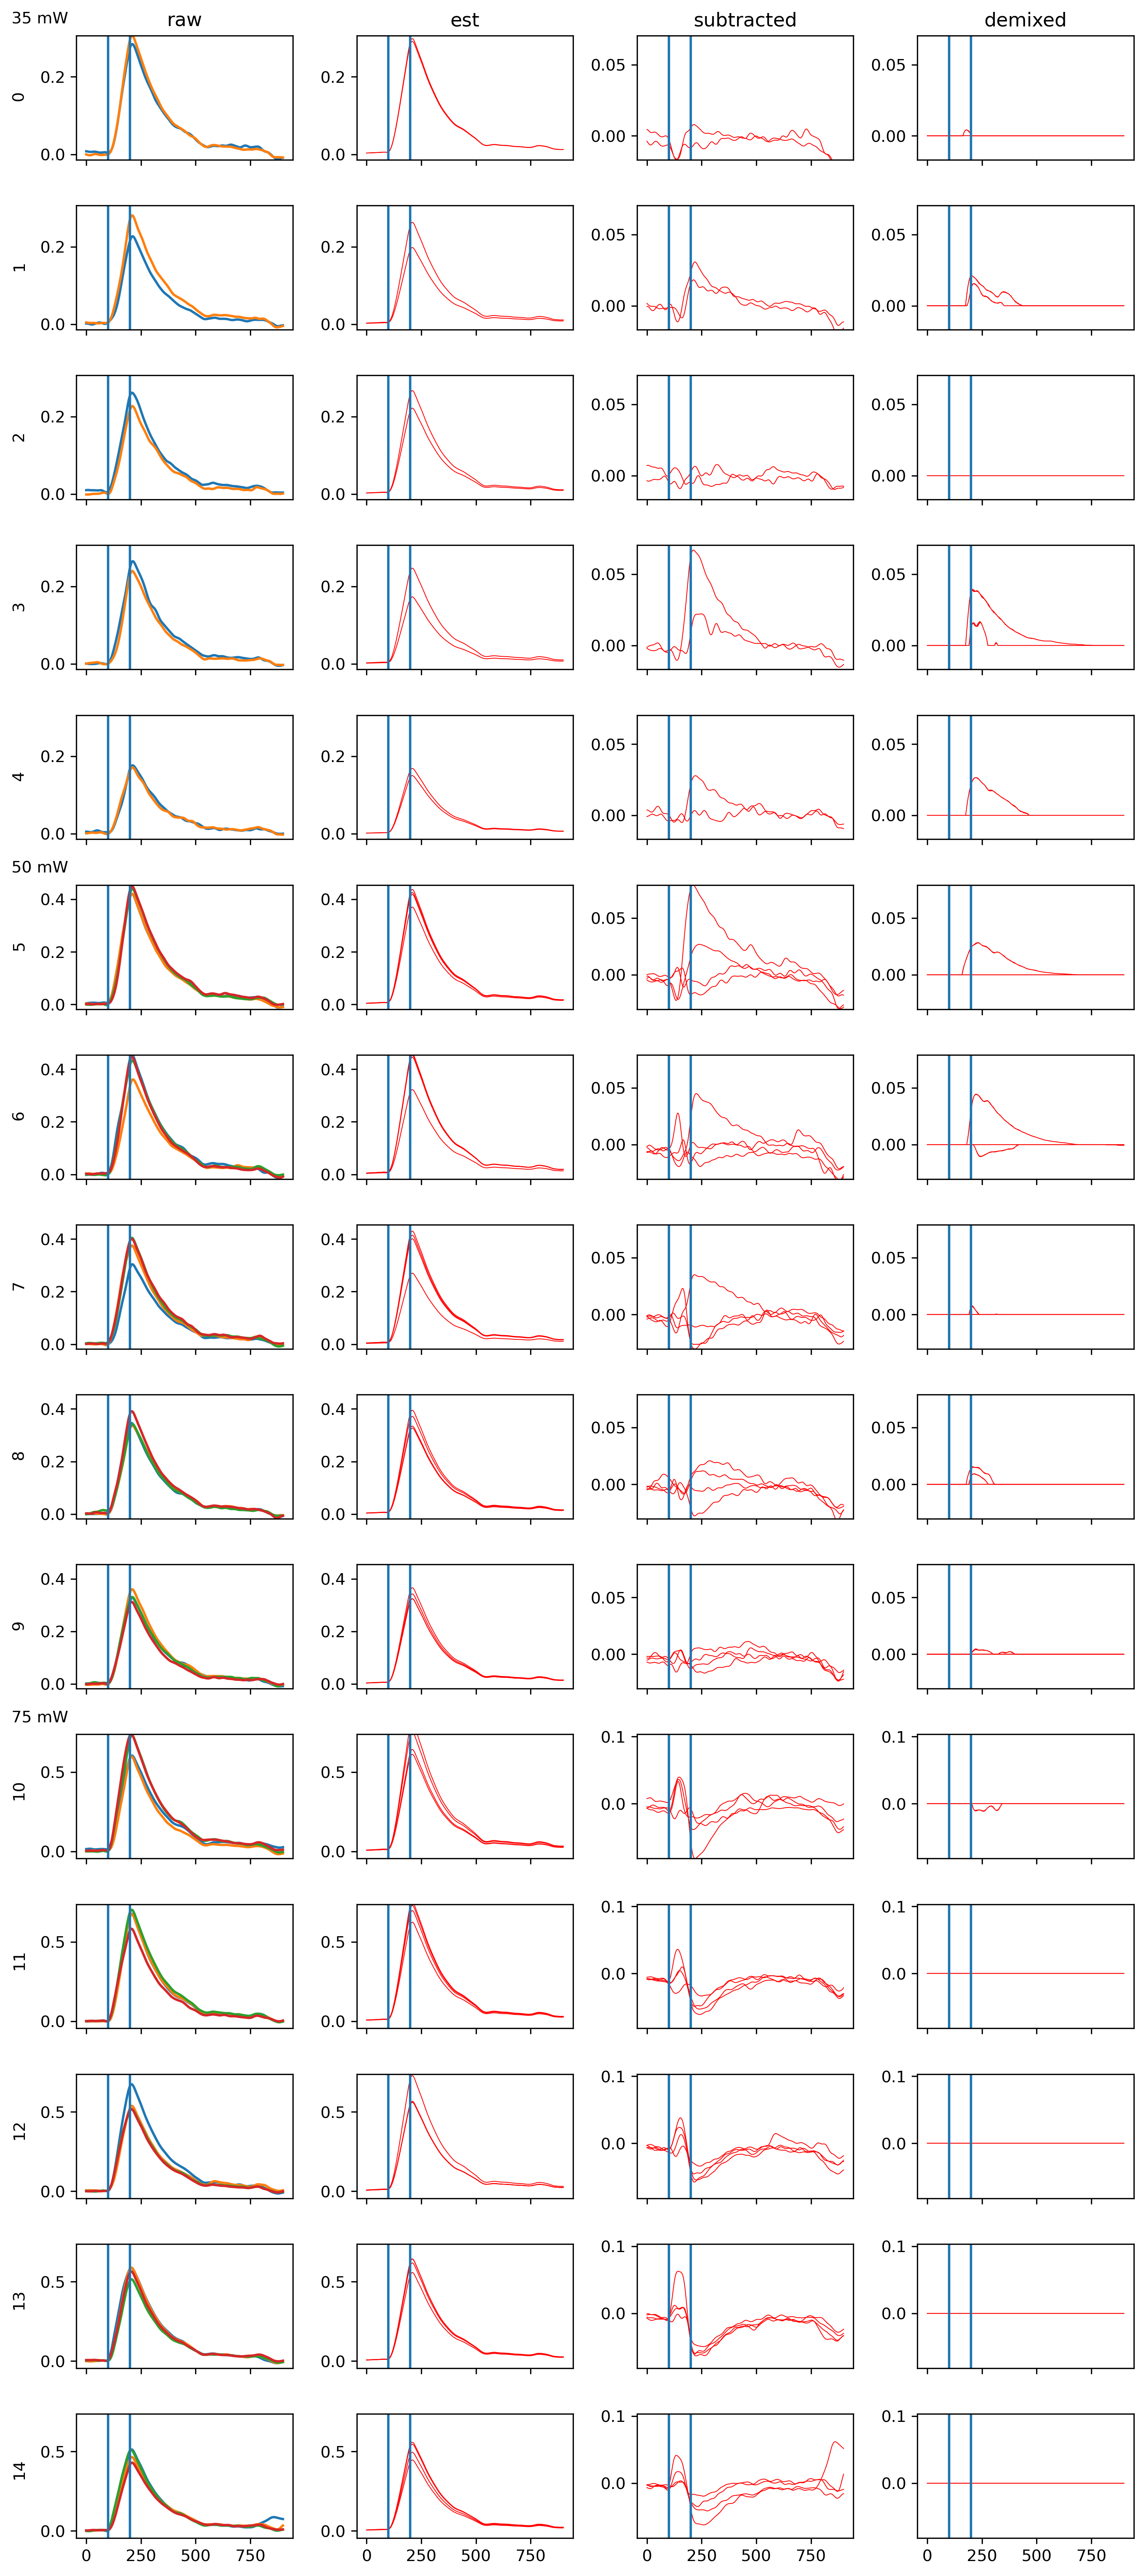

In [11]:
fig3, axs = subtract_utils.plot_subtraction_comparison(
        ss_results['raw_tensor'],
        [ss_results['est_tensor']],
        [ss_results['subtracted_tensor']],
        [ss_results['demixed_tensor']],
        powers=np.unique(ss_results['I']),
        num_plots_per_power=5,
)
# plt.savefig(dset_name + '_traces_' + '_unconstrained_V_baseline' + '.png', bbox_inches='tight')
plt.show()

In [6]:
g = stimgrid.make_manual_grid(
        xlims=(194, 325),
        ylims=(194, 325),
        zlims=(-75, 50),
        radial_spacing=5,
        axial_spacing=25
    )
grid_waveforms = make_grid_waveforms(ss_model, ss_results['demixed_matrix'], ss_results['I'], grid=g)
grid_latencies = grid_utils.make_grid_latencies(grid_waveforms)

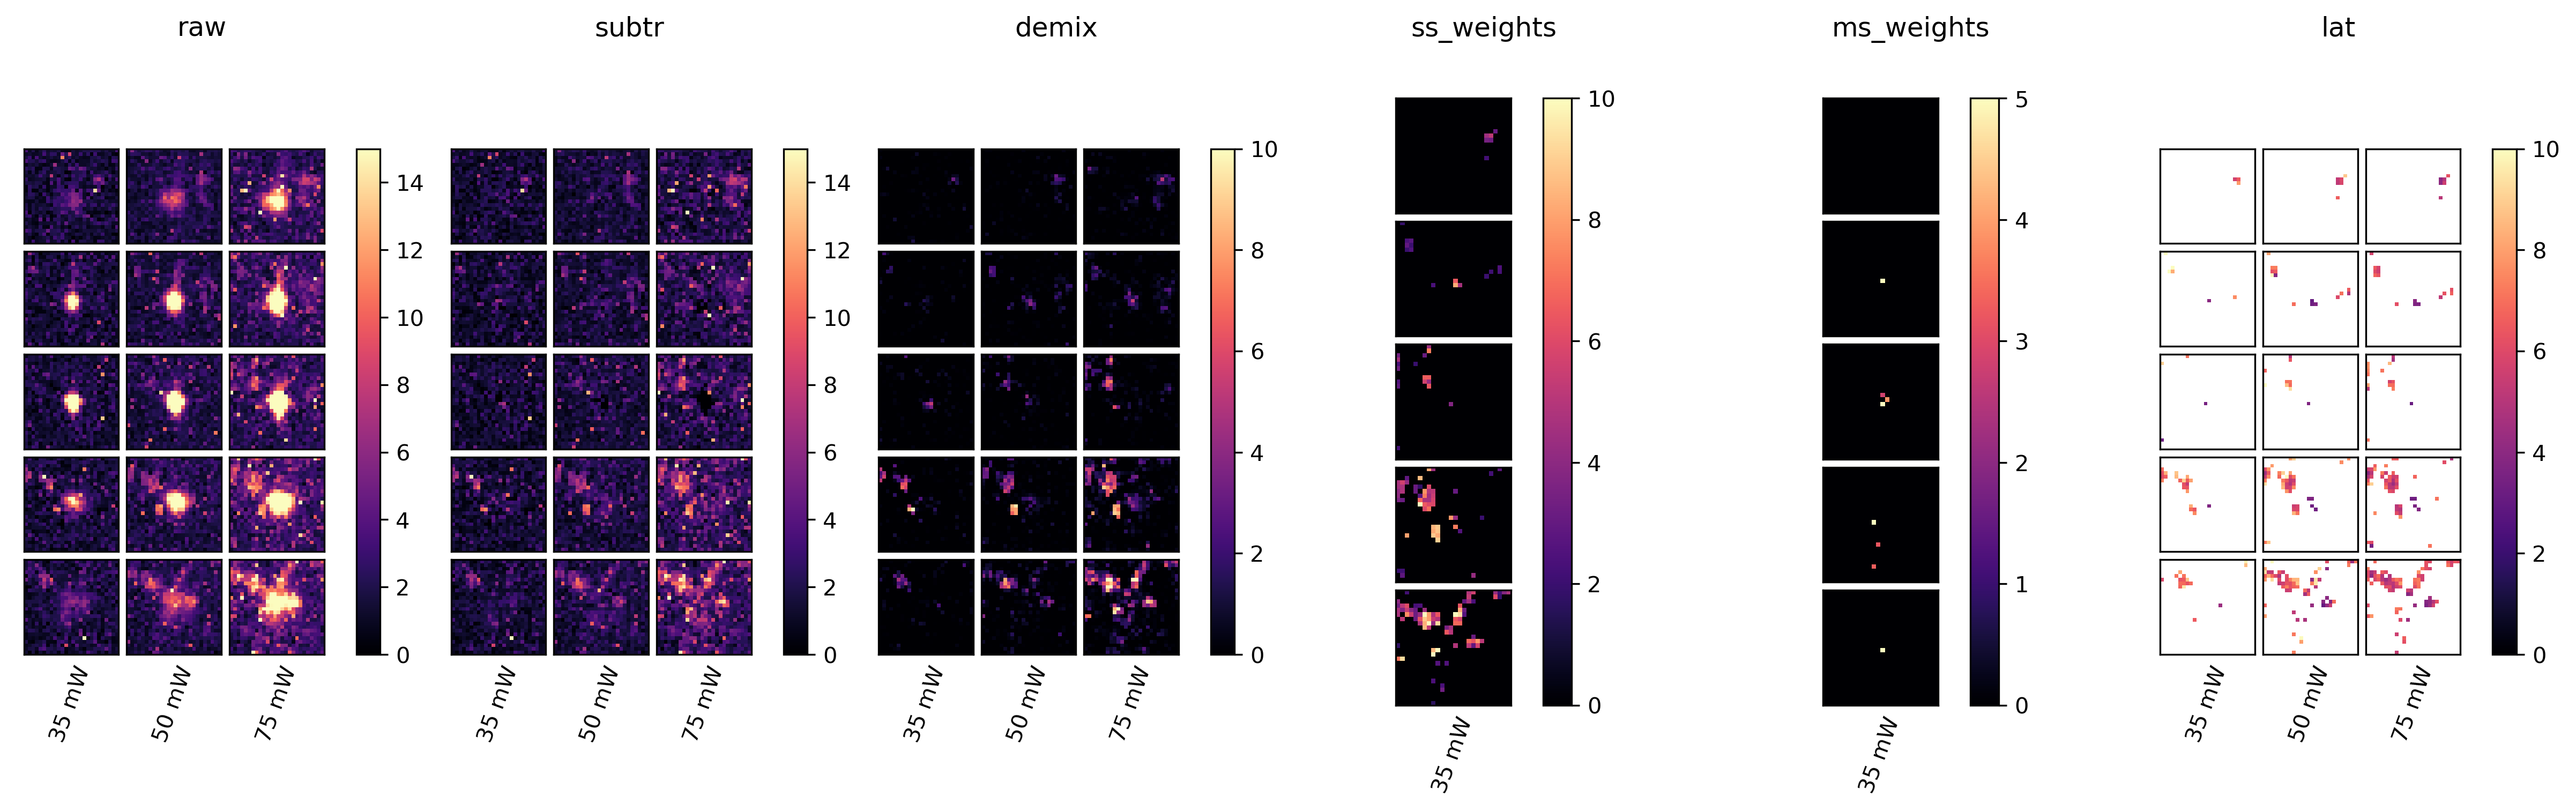

In [9]:
num_planes = ss_results['raw_map'].shape[-1]
fig2 = plt.figure(figsize=(4 * 5, num_planes), dpi=300, facecolor='white')

lat = grid_latencies.copy()
lat[lat == 0] = np.nan
lat -= 5
lat = np.swapaxes(lat, 1, 2)

grid_utils.plot_multi_means(fig2,
    [ss_results['raw_map'],
    ss_results['subtracted_map'],
    ss_results['demixed_map'],
    ss_weights[None,...],
    ms_weights[None,...],
    lat], np.arange(num_planes),
#     map_names=['subtracted'],
    cmaps=['magma', 'magma', 'magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['raw', 'subtr', 'demix', 'ss_weights', 'ms_weights', 'lat'],
    vranges=[(0,15), (0,15), (0,10), (0,10), (0,5), (0,10)],
    powers=np.unique(ss_results['I'])
    )

# plt.savefig(dset_name + '_maps.png', bbox_inches='tight')


In [26]:
np.max(ss_weights)

12.642324650486563

In [78]:
def plot_spike_inference_with_waveforms(den_psc, stim, I, model, waveforms, latencies,
                         spike_thresh=0.01, save=None, ymax=None, n_plots=15, num_trials=30, 
                         weights=None, col_width=10.5, row_height=0.6, order=None,
                         title=None, raw_psc=None, fontsize=14, draw_stim_start=True):
    N = stim.shape[0]
    K = den_psc.shape[0]
    trial_len = 900
    normalisation_factor = np.max(np.abs(den_psc))
    trace_linewidth = 0.65
    ymax = 1.05
    ymin = -0.05 * ymax
    
    mu = model.state['mu']
    mu /= np.max(mu)
    lam = model.state['lam']
    z = model.state['z']

    fig = plt.figure(figsize=(col_width, row_height * n_plots * 1.5), dpi=300, facecolor='white')
    
    # one columns for inferred waveforms
    powers = np.unique(I)
    width_ratios = np.zeros(len(powers) + 1)
    width_ratios[0:len(powers)] = 1
    width_ratios[-1] = n_plots
    gs = fig.add_gridspec(ncols=len(powers) + 1, nrows=n_plots, hspace=0.5, wspace=0.05, width_ratios=width_ratios)
        
    for m in range(n_plots):
        n = order[m]
        
        # spike predictions
        ax = fig.add_subplot(gs[m,-1])
        
        if title is not None and m == 0:
            plt.title(title, fontsize=fontsize, y=1.5)
            
        
        trials_per_power = num_trials // len(powers)
        stim_locs = np.array([])
        for pwr in powers:
            stim_locs = np.concatenate([stim_locs, np.where(stim[n] == pwr)[0][:trials_per_power]])
            
        stim_locs = stim_locs.astype(int)
        this_y_psc = den_psc[stim_locs].flatten()/normalisation_factor
        n_repeats = np.min([len(stim_locs), num_trials])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)
        
        if raw_psc is not None:
            this_y_psc_raw = raw_psc[stim_locs].flatten()/normalisation_factor

        plt.xlim([0, trial_len*n_repeats])
        
        # if we have ground truth weights
        if weights is None:
            trace_col = 'k'
        else:
            trace_col = 'k' if weights[n] != 0 else 'gray'
            
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                                 edgecolor='None', alpha=lam[n, stim_locs][tb] * mu[n], zorder=-5)

            if draw_stim_start:
                plt.axvline(x=100 + trial_len * tb,
                            color='grey',
                            linewidth=trace_linewidth, linestyle='-.')                 
            if z[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.75 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)
                
            # Plot power changes
            if (m == 0) and (I[stim_locs][tb] != I[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I[stim_locs][tb], fontsize=fontsize-2)
                
        plt.plot(this_y_psc, color=trace_col, linewidth=trace_linewidth)
        if raw_psc is not None:
            plt.plot(this_y_psc_raw, color='black', linewidth=trace_linewidth, alpha=0.9)
            
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
#         plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center')

        ax.set_rasterization_zorder(-2)
        
    if waveforms is not None:
        ### Inferred PSC waveforms ###
        waveform_colors=['blue','green','purple','red']

        for m in range(n_plots):
            n = order[m]
            

            for power_idx, power in enumerate(powers):
                ax = fig.add_subplot(gs[m,power_idx])
                
                plt.plot(waveforms[power_idx, n, :]/normalisation_factor,
                         color=waveform_colors[power_idx], linewidth=0.8 * trace_linewidth)
                
                # draw vertical line at inferred latency, first convert to index
                sample_khz = 20
                samples_per_sec = sample_khz * 1e3
                secs_per_sample = 1 / samples_per_sec
                msecs_per_sample = secs_per_sample * 1e3
                plt.axvline(x=(latencies[power_idx, n] / msecs_per_sample),
                            color=waveform_colors[power_idx],
                            linewidth=trace_linewidth, linestyle='-.')

                for loc in ['top', 'right', 'left', 'bottom']:
                    plt.gca().spines[loc].set_visible(False)
                plt.xticks([])
                plt.yticks([])
                plt.ylim([ymin, ymax])

    return fig

In [79]:
# for sorting by max observed charge
charge_per_location = np.nansum(results['raw_tensor'][-1,...], axis=(-1, -2)).ravel()
charge_order = np.argsort(charge_per_location)[::-1]

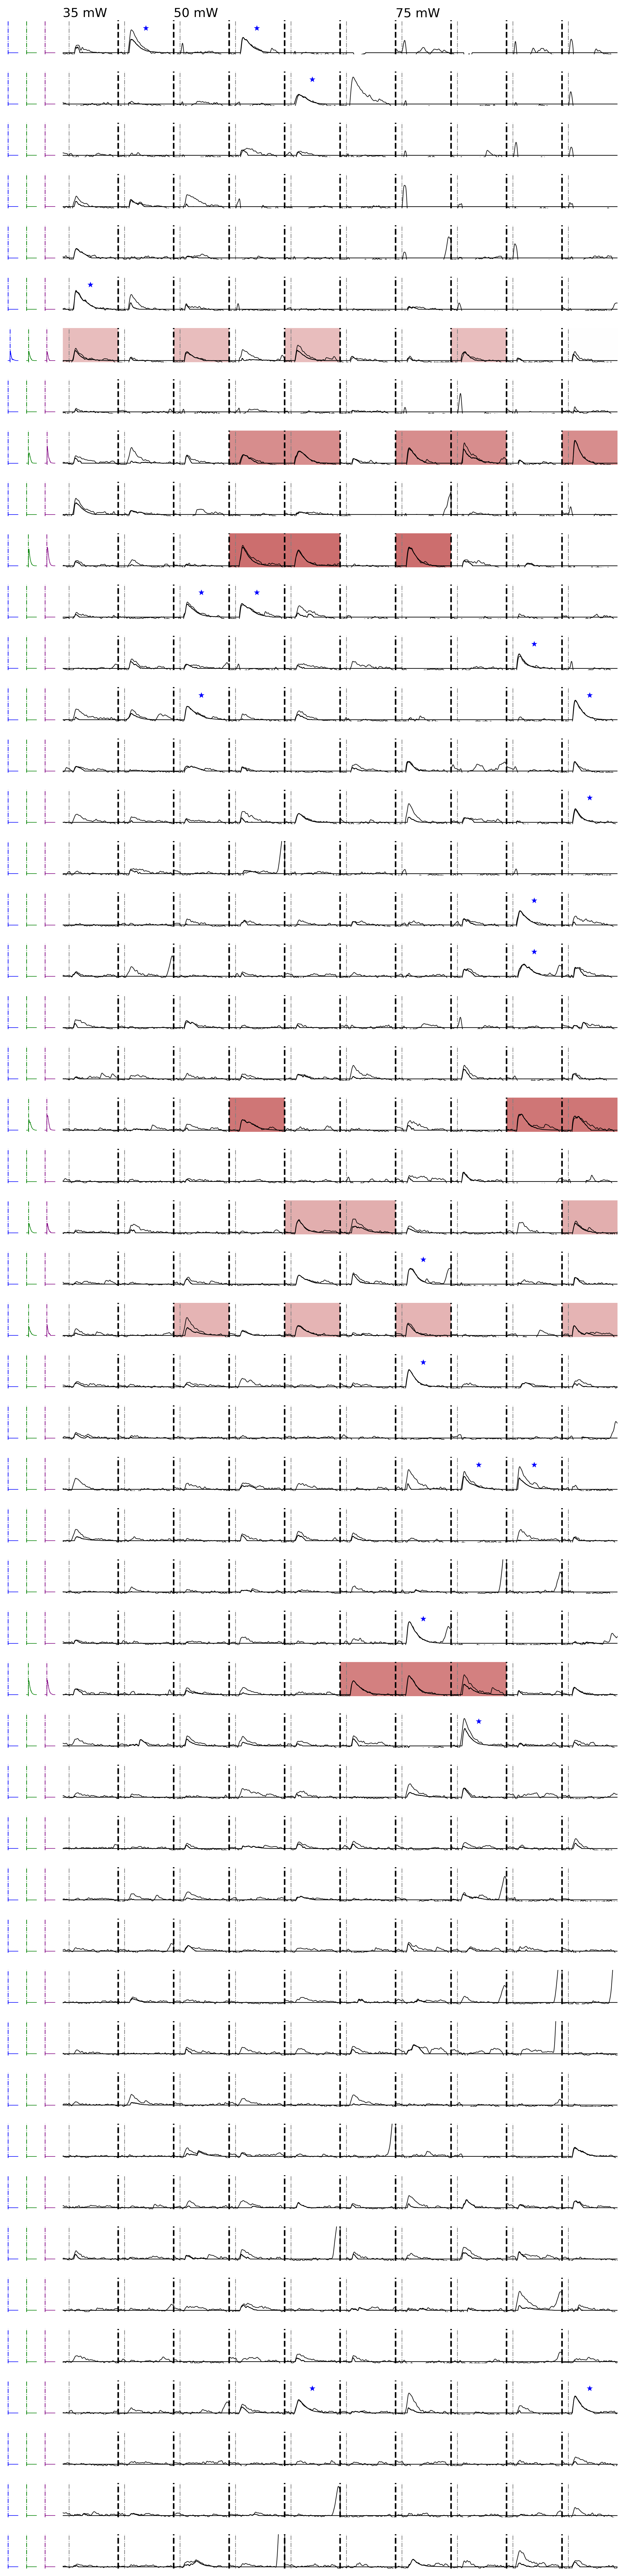

In [80]:
fontsize=14
num_powers = len(np.unique(results['I']))
fig = plot_spike_inference_with_waveforms(results['demixed_matrix'], results['stim_mat'], results['I'], results['model'].item(),
    waveforms=np.swapaxes(grid_waveforms, 1,2).reshape(num_powers, -1, 900),
    latencies=np.swapaxes(grid_latencies, 1,2).reshape(num_powers, -1,),
    # order = np.argsort(model.state['mu'])[::-1],
    order = charge_order,
    raw_psc=results['subtracted_matrix'],
    n_plots=50)
plt.savefig(dset_name + '_checker.png', bbox_inches='tight')

In [35]:
def plot_spike_inference_single_vs_multi(den_single, den_multi, model_single, model_multi, stim_single, stim_multi, 
                                         I_single, I_multi,
                                         raw_multi=None, raw_single=None,
                                         save=None, ymax=None, n_plots=15, max_trials_to_show=30, 
                                         trial_len=900, col_width=7.5, row_height=0.6, order=None, fontsize=14,
                                         true_weights=None):
    N = model_single.N
    K = den_single.shape[0]

    if ymax is None:
        ymax = np.percentile(den_multi/np.max(den_multi), 99.99)
    ymin = -0.05 * ymax
    
    lam_single = model_single.state['lam']
    mu_single = np.copy(model_single.state['mu'])
    if 'z' in model_single.state.keys():
        z_single = model_single.state['z']
    else:
        z_single = np.zeros(K)
    
    lam_multi = model_multi.state['lam']
    mu_multi = np.copy(model_multi.state['mu'])
    if 'z' in model_multi.state.keys():
        z_multi = model_multi.state['z']
    else:
        z_multi = np.zeros(K)
    
    mu_normalised_single = mu_single / (np.max(mu_single) + 1e-8)
    mu_normalised_multi = mu_multi / (np.max(mu_multi) + 1e-8)
    mu_order_single = np.argsort(mu_single)[::-1]

    # If no order is specified, sort by increasing order of single-target
    # inferred weights
    if order is None:
        order = mu_order_single.copy()
        
    # PSC inference
    lr = Ridge(fit_intercept=False, alpha=1e-3)
    lr.fit((lam_multi * (lam_multi >= 0.5)).T, den_multi)
    coef_multi = lr.coef_.T

    lr.fit((lam_single * (lam_single >= 0.5)).T, den_single)
    coef_seq = lr.coef_.T
    
    # Plotting params
    num_trials_single = np.sum(stim_single[0] > 0)
    num_trials_multi = max_trials_to_show

    fig = plt.figure(figsize=((1 + num_trials_multi/num_trials_single) * col_width, row_height * n_plots * 1.5), facecolor='white', dpi=300)
    gs = fig.add_gridspec(ncols=3, nrows=n_plots, hspace=0.5, wspace=0.05, width_ratios=[1, 1/num_trials_single, num_trials_multi/num_trials_single])
    
    normalisation_factor = np.max(np.abs(den_multi))
#     normalisation_factor = 1.0
    trace_linewidth = 0.65
    
    ###  Single-target responses  ###
    for m in range(n_plots):
        n = order[m]
        
        # spike predictions
        ax = fig.add_subplot(gs[m, 0])
        if m == 0:
            plt.title('Single target', fontsize=fontsize, y=1.5)
        stim_locs_unsrt = np.where(stim_single[n] > 0)[0]
        stim_locs = stim_locs_unsrt[np.argsort(I_single[stim_locs_unsrt])]
        this_y_psc = den_single[stim_locs].flatten()/normalisation_factor
        
        if raw_single is not None:
            this_y_psc_raw = raw_single[stim_locs].flatten()/normalisation_factor

        n_repeats = np.min([len(stim_locs_unsrt), max_trials_to_show])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)
        
        plt.xlim([0, trial_len*n_repeats])
        trace_col = 'k' if mu_single[n] != 0 else 'gray'
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            if not np.isnan(mu_normalised_single[n]):
                ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                                 edgecolor='None', alpha=lam_single[n, stim_locs][tb] * mu_normalised_single[n], zorder=-5)
            
            if z_single[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.75 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)
                        
            # Plot power changes
            if (m == 0) and (I_single[stim_locs][tb] != I_single[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I_single[stim_locs][tb], fontsize=fontsize-2)
                
        plt.plot(this_y_psc, color='k', linewidth=trace_linewidth)
        
        if raw_single is not None:
            plt.plot(this_y_psc_raw, color='grey', linewidth=trace_linewidth)
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
        if true_weights is not None:
            label_col = 'k' if true_weights[n] != 0 else 'gray'
        else:
            label_col = 'k'
        plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center', color=label_col)

        ax.set_rasterization_zorder(-2)
        
    ### Inferred PSC waveforms ###
    for m in range(n_plots):
        n = order[m]
        
        ax = fig.add_subplot(gs[m, 1])
        
        plt.plot(coef_seq[n]/normalisation_factor, color='gray', linewidth=trace_linewidth)
        plt.plot(coef_multi[n]/normalisation_factor, color='k', linewidth=trace_linewidth)
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
        
    ###  Multi-target responses  ###
    for m in range(n_plots):
        n = order[m]
        
        
        # spike predictions
        ax = fig.add_subplot(gs[m, 2])
        if m == 0:
            plt.title('Multi target', fontsize=fontsize, y=1.5)
        
        powers = np.unique(I_multi)
        trials_per_power = num_trials_multi // len(powers)
        stim_locs = np.array([])
        for pwr in powers:
            stim_locs = np.concatenate([stim_locs, np.where(stim_multi[n] == pwr)[0][:trials_per_power]])
        
        stim_locs = stim_locs.astype(int)
        this_y_psc = den_multi[stim_locs].flatten()/normalisation_factor
        
        if raw_multi is not None:
            this_y_psc_raw = raw_multi[stim_locs].flatten()/normalisation_factor
            
        n_repeats = np.min([len(stim_locs), max_trials_to_show])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)

        plt.xlim([0, trial_len*n_repeats])
        trace_col = 'k' if mu_multi[n] != 0 else 'gray'
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                             edgecolor='None', alpha=lam_multi[n, stim_locs][tb] * mu_normalised_multi[n], zorder=-5)
            
            if z_multi[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.9 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)

            # Plot power changes
            if (m == 0) and (I_multi[stim_locs][tb] != I_multi[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I_multi[stim_locs][tb], fontsize=fontsize-2)
            
            # Annotate estimated spiking cells
            
            inferred_spiking_cells = np.where(model_multi.state['lam'][:, stim_locs][:, tb] >= 0.5)[0]
            
            
                
            annotated_cells = np.intersect1d(inferred_spiking_cells, np.where(mu_multi != 0)[0])
            annotated_locs = np.array([np.where(order == i)[0][0] + 1 for i in annotated_cells])
            plt.text(trial_breaks[tb], -0.3, ','.join(annotated_locs.astype(str).tolist()), fontsize=7)
            
            # debugging: find cells which spike, but are labeled neither as sponts nor as assigned spikes
            if (inferred_spiking_cells.size > 0) and (annotated_locs.size == 0): 
                import pdb; pdb.set_trace()   
                    
        plt.plot(this_y_psc, color=trace_col, linewidth=trace_linewidth)
        
        if raw_single is not None:
            plt.plot(this_y_psc_raw, color='grey', linewidth=trace_linewidth)
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
#         plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center')

        ax.set_rasterization_zorder(-2)
    
    if save is not None:
        plt.savefig(save, format='png', bbox_inches='tight', dpi=200, facecolor='white')
    plt.show()


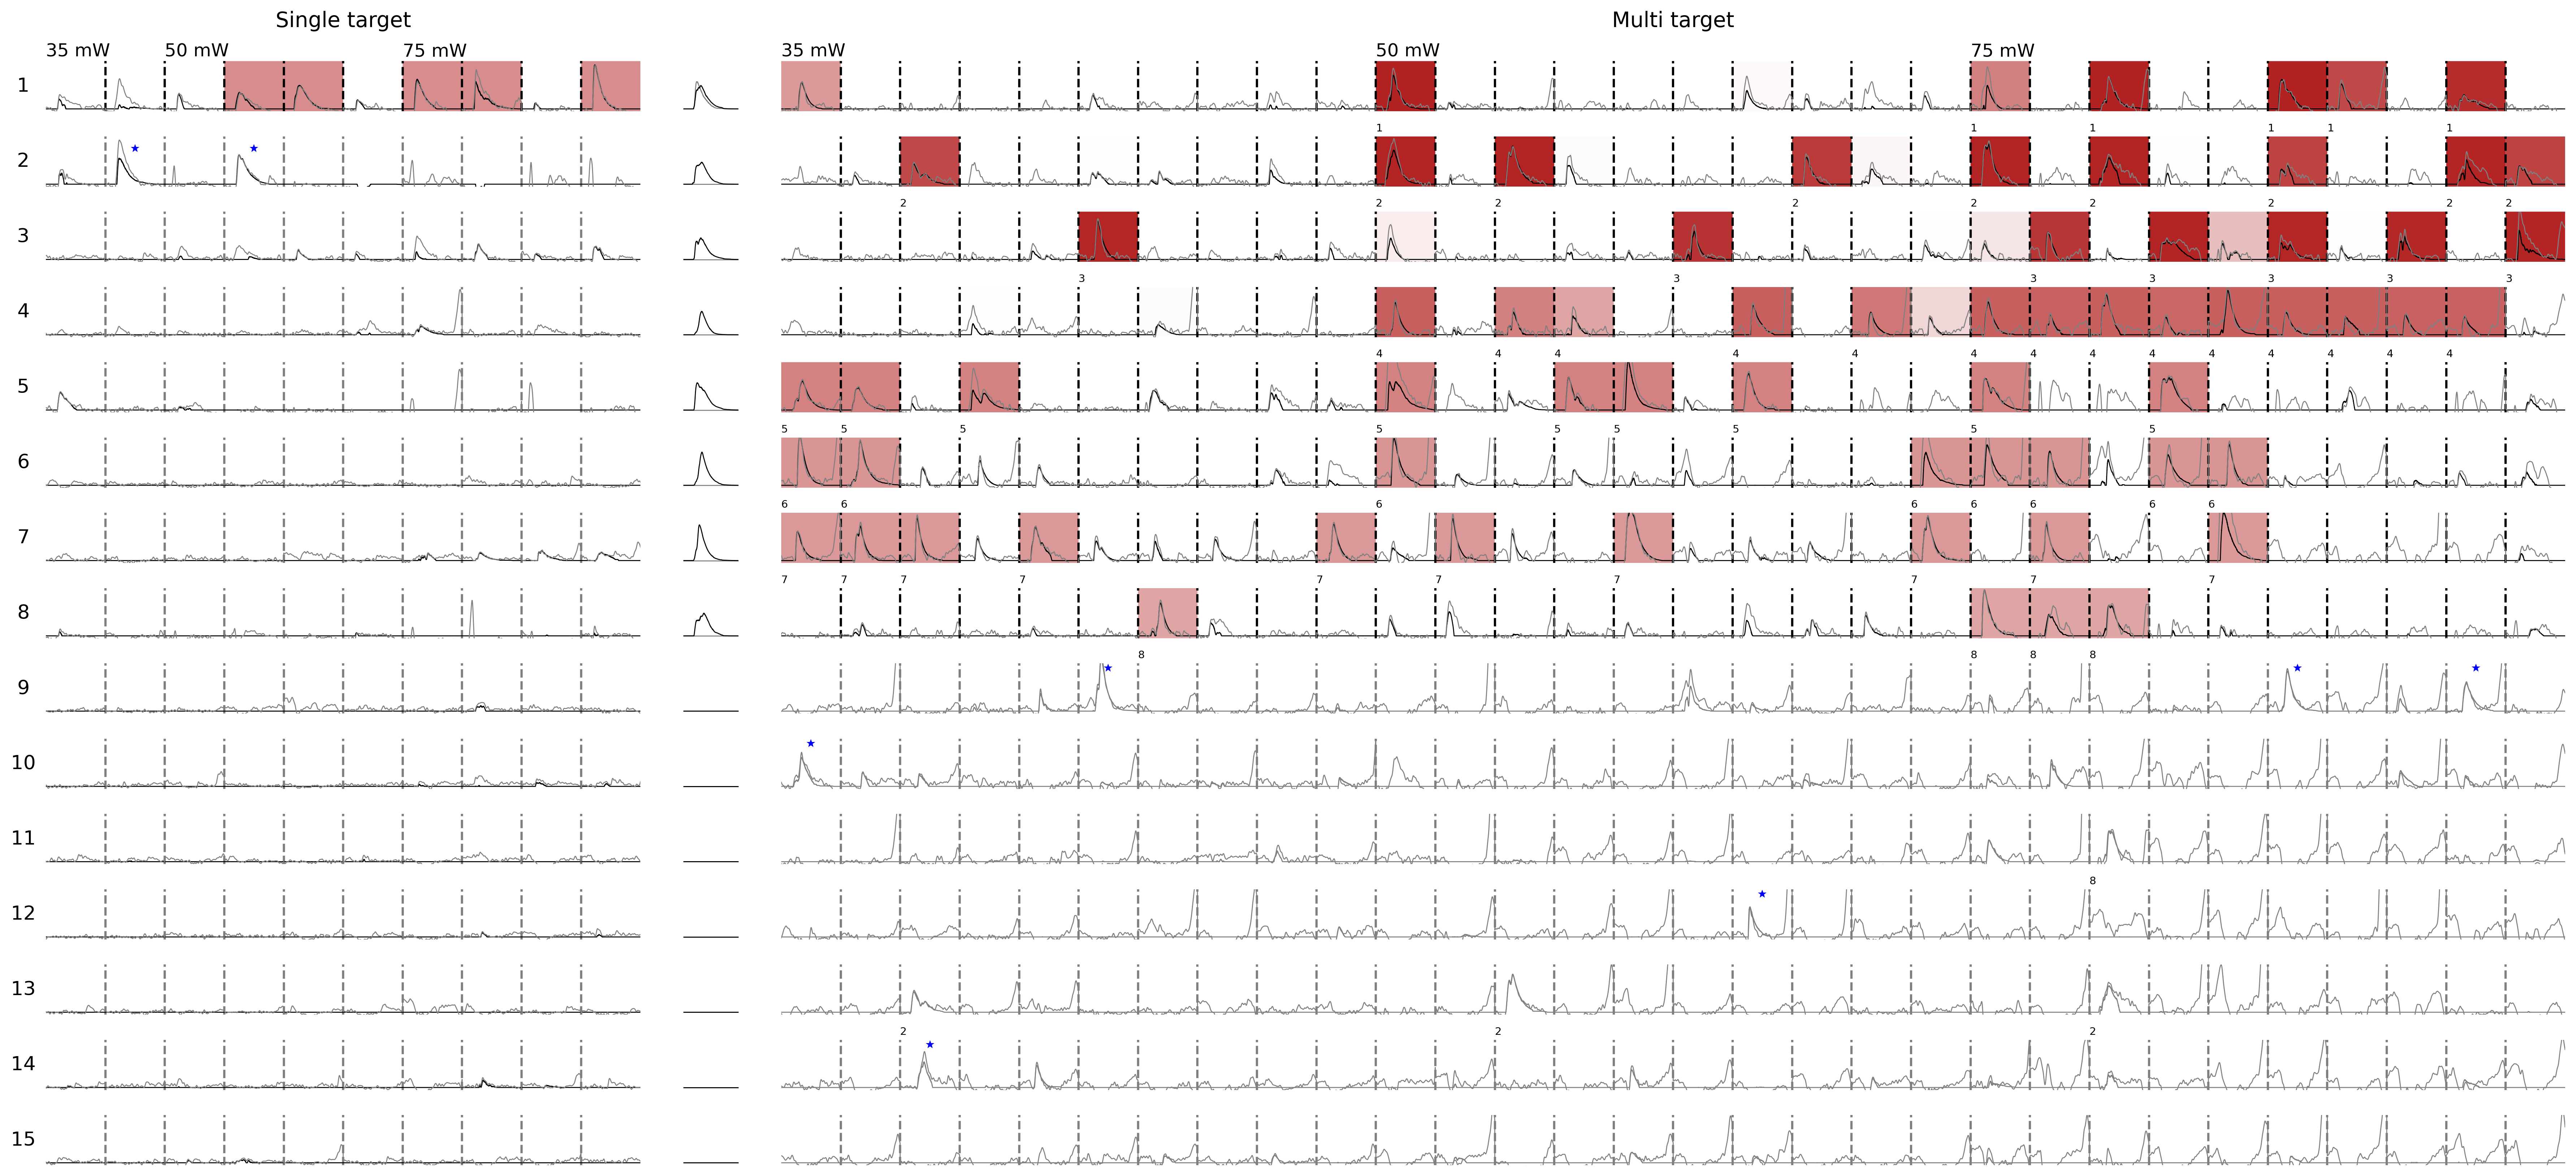

In [38]:
plot_spike_inference_single_vs_multi(
    ss_results['demixed_matrix'],
    ms_results['demixed_matrix'],
    ss_model,
    ms_model,
    stim_single=ss_results['stim_mat'],
    stim_multi=ms_results['stim_mat'],
    I_single=ss_results['I'],
    I_multi=ms_results['I'],
    raw_single=ss_results['subtracted_matrix'],
    raw_multi=ms_results['subtracted_matrix'],
    order = np.argsort(ms_model.state['mu'])[::-1]
)

In [39]:
np.sum(ms_model.state['mu'] > 0)

8

In [40]:
np.sum(ss_model.state['mu'] > 0)

176